# Spatial Modelling with Pyspatialml

## Multi-Target Spatial Prediction using the Meuse Dataset

Here we are using the meuse dataset which is included in the pyspatialml package as an example of performing a spatial model and prediction. We can access the datasets using the `pyspatialml.datasets` module:

In [1]:
from copy import deepcopy
from tempfile import NamedTemporaryFile
import geopandas as gpd
import numpy as np
from pyspatialml import Raster
from pyspatialml.preprocessing import xy_coordinates, distance_to_corners
import pyspatialml.datasets.meuse as ms

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


In [2]:
predictor_files = ms.predictors
training_pts_file = ms.meuse

In [3]:
stack = Raster(predictor_files)
stack.names

dict_keys(['chnl_dist', 'dem', 'dist', 'ffreq', 'landimg2', 'landimg3', 'landimg4', 'mrvbf', 'rsp', 'slope', 'soil', 'twi'])

Pyspatialml implements pandas-style indexing for `Raster` objects, using `Raster.loc` to index by the name of the raster, and `Raster.iloc` to select by index. This method also accepts slices. Label-based indexing is also provided directly by the __getattr_ magic method, i.e. `Raster[name]` or for multiple layers `Raster[(names)]`.

For example we can remove layers from Raster object using the `Raster.drop` method, or by subsetting the raster:

In [4]:
stack.drop('ffreq')

Raster Object Containing 11 Layers
    attribute                                             values
0       names  [chnl_dist, dem, dist, landimg2, landimg3, lan...
1       files  [/Users/stevenpawley/Documents/GitHub/Pyspatia...
2        rows                                                104
3        cols                                                 78
4         res                                       (40.0, 40.0)
5  nodatavals  [-99999.0, -99999.0, -1.0, -1.0, -1.0, -1.0, -...


We can store matplotlib cmaps as an attribute within each layer in the Raster:

In [5]:
stack.chnl_dist.cmap = 'RdBu'
stack.dem.cmap = 'terrain'
stack.dist.cmap = 'Reds'
stack.landimg2.cmap = 'Greys'
stack.landimg3.cmap = 'Greys'
stack.landimg4.cmap = 'Greys'
stack.landimg4.cmap = 'Greys'
stack.mrvbf.cmap = 'jet'
stack.rsp.cmap = 'gnuplot2'
stack.slope.cmap = 'PuRd'
stack.soil.cmap = cm.get_cmap('Set2', 3)
stack.twi.cmap = 'coolwarm'

Plot the predictors in the Raster object as a raster matrix:

/var/folders/hy/tgvjqg6502s0jfgtmt4pbng00000gn/T/ipykernel_47504/2543982748.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-ticks')


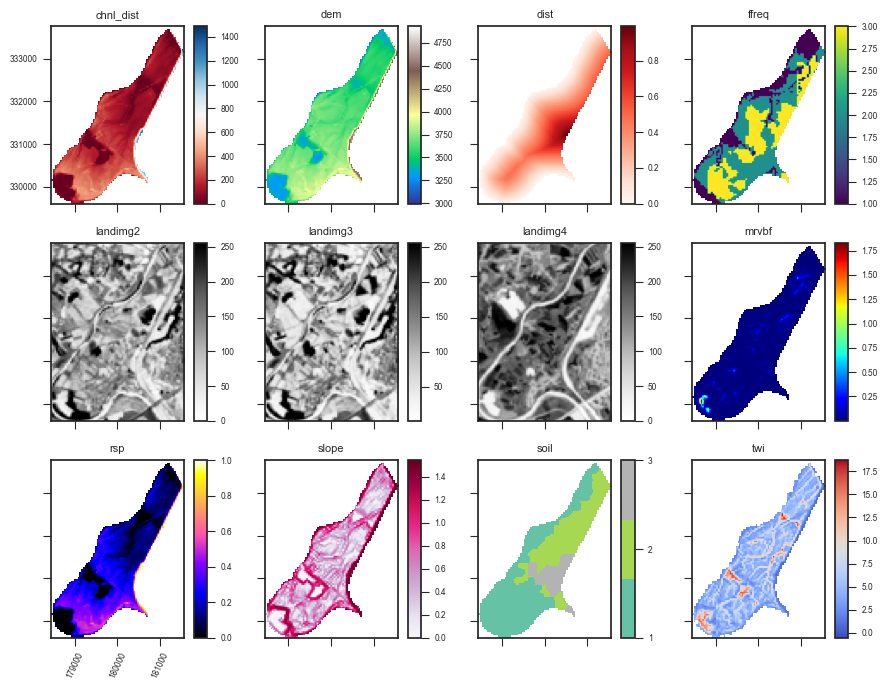

In [6]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

## Feature Engineering

We want the prediction results to be depend on the spatial locations of the training data. So to include spatial information, coordinate grids can be generated and added to the Raster object:

In [7]:
xy_layer = xy_coordinates(
    layer=stack.iloc[0], 
    file_path=NamedTemporaryFile(suffix=".tif").name
)

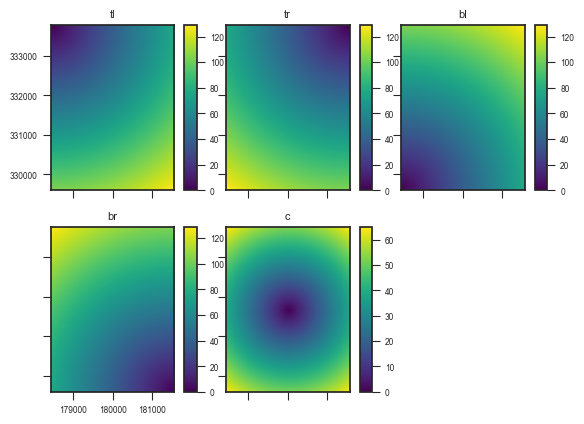

In [8]:
xy_layer = xy_coordinates(
    layer=stack.iloc[0], 
    file_path=NamedTemporaryFile(suffix=".tif").name
)

edms = distance_to_corners(
    layer=stack.iloc[0], 
    file_path=NamedTemporaryFile(suffix=".tif").name
)
edms.rename(
    {old: new for (old, new) in zip(edms.names, ["tl", "tr", "bl", "br", "c"])},
    in_place=True
)

edms.plot()
plt.show()

Append them to the Raster object:

In [9]:
stack = stack.append([xy_layer, edms])

Plot the new predictors:

/var/folders/hy/tgvjqg6502s0jfgtmt4pbng00000gn/T/ipykernel_47504/2543982748.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-ticks')


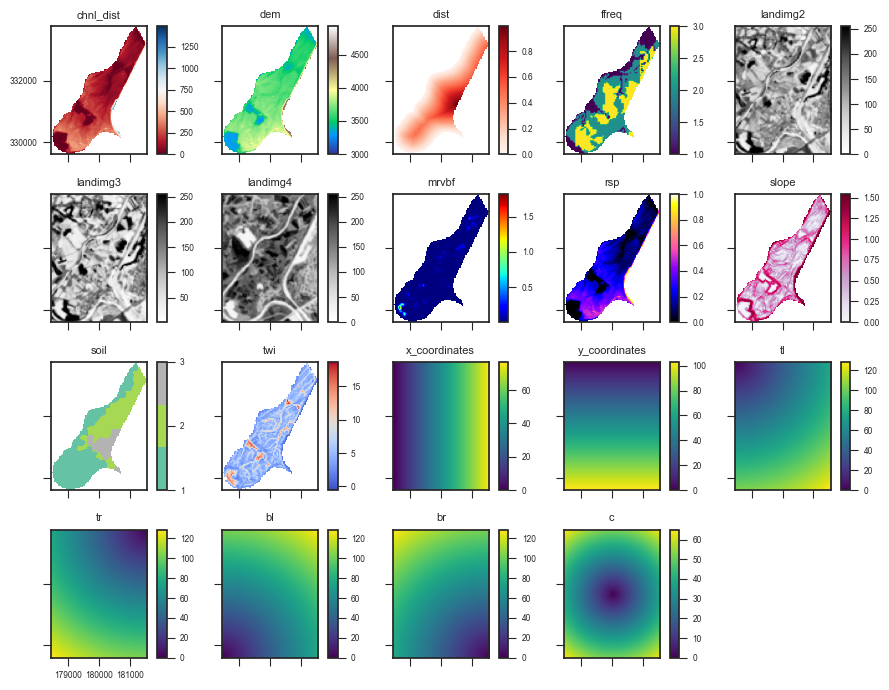

In [10]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

The area that is filled by some of the grids is different. This doesn't matter for the prediction because pixels in the Raster object that include some NaNs in some of the layers will be removed. However, the plots could potentially be given a cleaner look. We can use the Raster.intersect method to fix this:

In [11]:
stack = stack.intersect()

/var/folders/hy/tgvjqg6502s0jfgtmt4pbng00000gn/T/ipykernel_47504/2543982748.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-ticks')


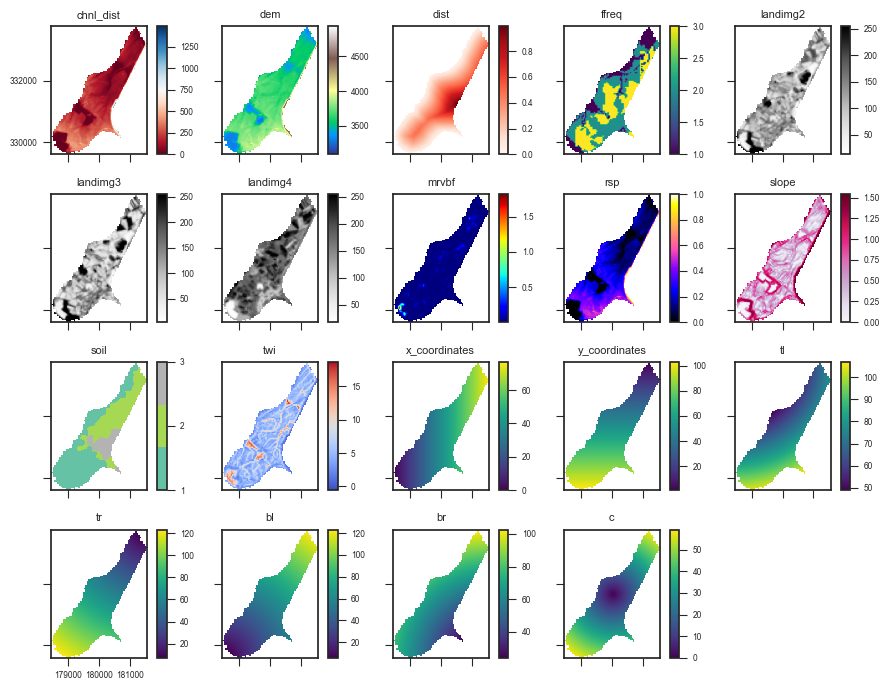

In [12]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

## Read the Meuse Dataset

In [13]:
training_pts = gpd.read_file(training_pts_file)
training_pts.head()

,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,geometry
0,11.7,85.0,299.0,1022.0,7.909,0.001358,13.6,1,1,1,Ah,50.0,POINT (181072.000 333611.000)
1,8.6,81.0,277.0,1141.0,6.983,0.012224,14.0,1,1,1,Ah,30.0,POINT (181025.000 333558.000)
2,6.5,68.0,199.0,640.0,7.800,0.103029,13.0,1,1,1,Ah,150.0,POINT (181165.000 333537.000)
3,2.6,81.0,116.0,257.0,7.655,0.190094,8.0,1,2,0,Ga,270.0,POINT (181298.000 333484.000)
4,2.8,48.0,117.0,269.0,7.480,0.277090,8.7,1,2,0,Ah,380.0,POINT (181307.000 333330.000)


Plot the training points:

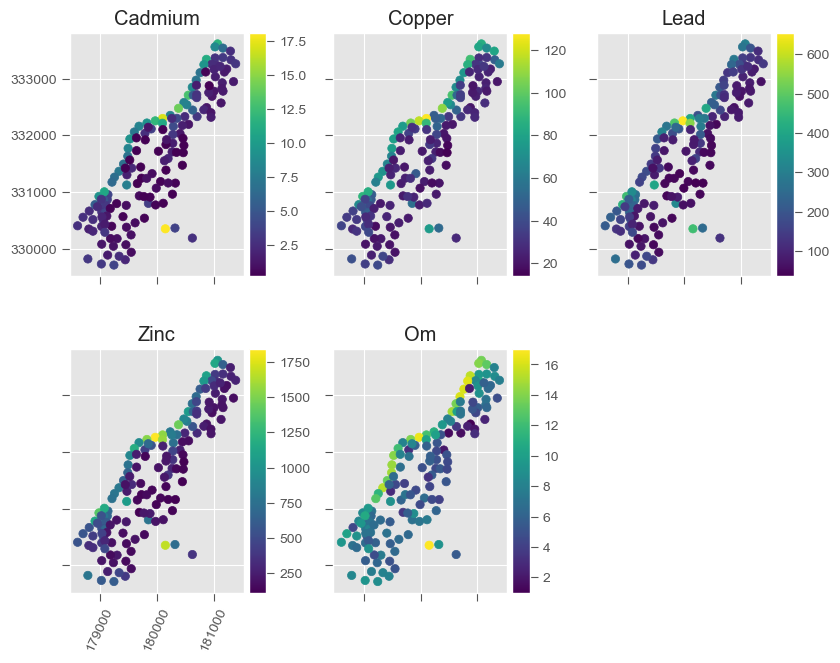

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')

fig, axs = plt.subplots(2, 3, figsize=(8.5, 7))

for i, (ax, target) in enumerate(zip(axs.ravel(), ['cadmium', 'copper', 'lead', 'zinc', 'om'])):
    ax.set_title(target.title())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)
    training_pts.plot(column=target, legend=True, ax=ax, cax=cax, cmap='viridis')
    
    if i != 0:
        ax.set_yticklabels([])
    
    if i != 3:
        ax.set_xticklabels([])
    else:
        ax.tick_params(axis='x', labelrotation=65)
    
fig.delaxes(axs.flatten()[i+1])
plt.tight_layout()
plt.show()

## Extract Raster Values at the Training Point Locations

Pixel values from a Raster object can be extracted using geometries within a geopandas.GeoDataFrame (points, lines, polygons) or by using labelled pixels from another raster with the same dimensions and crs.

By default the extracted values are returned as a geopandas.GeoDataFrame that contains the data and the coordinates of the pixels:

In [15]:
training_df = stack.extract_vector(gdf=training_pts)

training_df.index = training_df.index.get_level_values("geometry_idx")
training_df = training_df.merge(
    training_pts.loc[:, ("lead", "cadmium", "copper", "zinc", "om")], 
    left_index=True, 
    right_index=True
) 

In [16]:
training_df = training_df.dropna()
training_df.head()

,chnl_dist,dem,dist,ffreq,landimg2,landimg3,landimg4,mrvbf,rsp,slope,...,tr,bl,br,c,geometry,lead,cadmium,copper,zinc,om
geometry_idx,,,,,,,,,,,,,,,,,,,,,
0,0.000000,3214.0,0.001358,1.0,97.0,92.0,192.0,3.523824e-06,0.000000,1.423307,...,12.369317,119.268608,100.717430,55.470715,POINT (181072.000 333611.000),299.0,11.7,85.0,1022.0,13.6
1,79.849854,3402.0,0.012224,1.0,160.0,183.0,183.0,9.879866e-06,0.082085,1.286004,...,13.928389,117.046997,98.858482,53.235325,POINT (181025.000 333558.000),277.0,8.6,81.0,1141.0,14.0
2,0.000000,3277.0,0.103029,1.0,178.0,209.0,179.0,1.340742e-03,0.000000,0.674711,...,10.295630,119.281181,98.412399,55.226807,POINT (181165.000 333537.000),199.0,6.5,68.0,640.0,13.0
3,184.743164,3563.0,0.190094,1.0,114.0,135.0,152.0,6.547428e-07,0.192325,1.413479,...,8.485281,120.208153,97.185387,56.035702,POINT (181298.000 333484.000),116.0,2.6,81.0,257.0,8.0
4,16.768555,3406.0,0.277090,1.0,133.0,154.0,151.0,1.588824e-03,0.016689,0.531276,...,11.661903,117.004272,93.193344,52.801514,POINT (181307.000 333330.000),117.0,2.8,48.0,269.0,8.7


## Developing a Machine Learning Model

Here we are going to create a machine learning pipeline that correctly handles categorical predictors via one-hot encoding:

In [17]:
stack.names

dict_keys(['chnl_dist', 'dem', 'dist', 'ffreq', 'landimg2', 'landimg3', 'landimg4', 'mrvbf', 'rsp', 'slope', 'soil', 'twi', 'x_coordinates', 'y_coordinates', 'tl', 'tr', 'bl', 'br', 'c'])

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

soil_idx = [i for i, name in enumerate(stack.names) if name == 'soil']

trans = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), soil_idx)
    ], remainder='passthrough')

et = ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=1234)
et = Pipeline([
    ('preproc', trans),
    ('regressor', et)])

Now we can separate our response and predictor variables and train the model:

In [19]:
X = training_df.loc[:, stack.names]
y = training_df.loc[:, ['lead', 'cadmium', 'copper', 'zinc', 'om']]
et.fit(X, y)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [10])])),
                ('regressor',
                 ExtraTreesRegressor(n_estimators=500, n_jobs=-1,
                                     random_state=1234))])

To evaluate the performance of the model, we will use 10-fold cross validation:

In [20]:
from sklearn.model_selection import cross_validate, KFold

outer = KFold(n_splits=10, shuffle=True, random_state=1234)
scores = cross_validate(et, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=1)
rmse = np.sqrt(-scores['test_score']).mean()

print("Our RMSE score is {}".format(rmse))

Our RMSE score is 105.19227221271413


## Feature Importances

In [21]:
ohe_names = deepcopy(list(stack.names))
ohe_names.insert(soil_idx[0], 'soil1')
ohe_names.insert(soil_idx[0], 'soil2')
ohe_names = np.array(ohe_names)

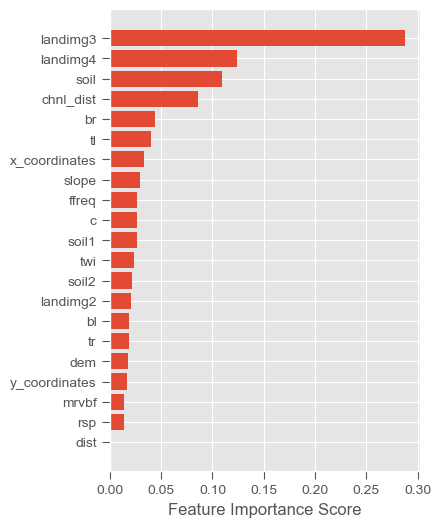

In [22]:
mpl.style.use('ggplot')

fimp = et.named_steps['regressor'].feature_importances_

fig, ax = plt.subplots(figsize=(4, 6))
ax.barh(y=ohe_names[fimp.argsort()], width=fimp[fimp.argsort()])
ax.set_xlabel('Feature Importance Score')
plt.show()

## Prediction on the Raster object

In [23]:
preds = stack.predict(et)
preds.rename(
    {old: new for old, new in zip(preds.names, ['lead', 'cadmium', 'copper', 'zinc', 'om'])},
    in_place=True
)
preds.lead.cmap = 'rainbow'
preds.cadmium.cmap = 'rainbow'
preds.copper.cmap = 'rainbow'
preds.zinc.cmap = 'rainbow'
preds.om.cmap = 'rainbow'

/Users/stevenpawley/mambaforge/envs/spatial/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/Users/stevenpawley/mambaforge/envs/spatial/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Plot the results:

/var/folders/hy/tgvjqg6502s0jfgtmt4pbng00000gn/T/ipykernel_47504/3208474620.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-ticks')


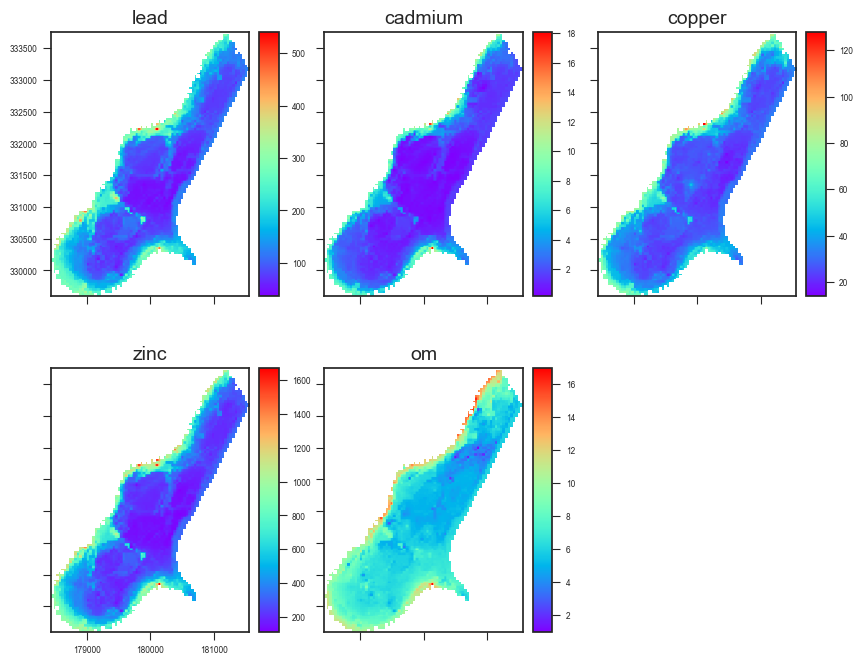

In [24]:
mpl.style.use('seaborn-ticks')
preds.plot(out_shape=(200, 200), title_fontsize=14, figsize=(10, 8))
plt.show()